# 4.NLP based model to perform sentiment analysis on the coronavirus

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
import nltk
import warnings
import re
import math
warnings.filterwarnings('ignore')
import preprocessor as tp # fpr preprocessing tweets
from ekphrasis.classes.segmenter import Segmenter 
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,classification_report,confusion_matrix,plot_confusion_matrix,matthews_corrcoef

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV



# Reading Data

In [2]:
twitter_df=pd.read_csv("C:\\Users\\harsh\\Downloads\\Corona_NLP_train.csv")

In [3]:
twitter_df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know its getting tough when @KameronWilds...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


# Data analysis

In [4]:
twitter_df.describe()

,UserName,ScreenName
count,41157.000000,41157.000000
mean,24377.000000,69329.000000
std,11881.146851,11881.146851
min,3799.000000,48751.000000
25%,14088.000000,59040.000000
50%,24377.000000,69329.000000
75%,34666.000000,79618.000000
max,44955.000000,89907.000000


In [5]:
twitter_df.isna().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [6]:
twitter_df['Sentiment'].unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

<AxesSubplot:ylabel='UserName'>

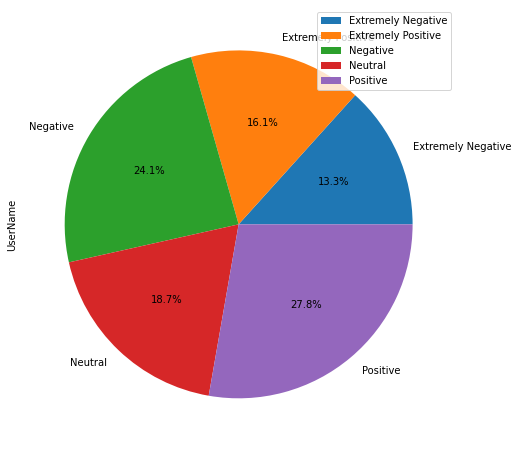

In [7]:
twitter_df.groupby(['Sentiment']).count().plot(kind='pie',y='UserName',figsize=(8,8),autopct='%1.1f%%')

The dataset contains unequal records for each class and hence it is a "IMBALANCED" dataset.  
We can infer that we have maximum samples for positive and minimum samples for Extremely Negative.


<AxesSubplot:xlabel='Sentiment'>

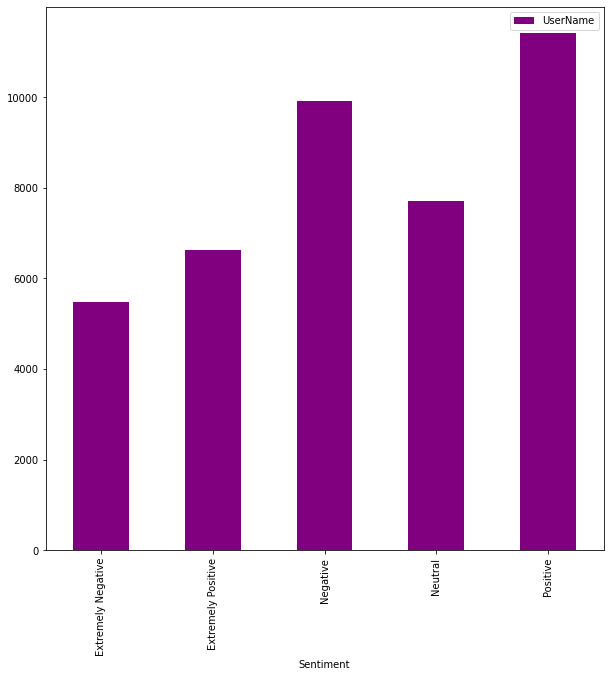

In [8]:
twitter_df.groupby(['Sentiment']).count().plot(kind='bar',y='UserName',figsize=(10,10),color='purple')

In [9]:
twitter_df.groupby(['Sentiment']).count()

,UserName,ScreenName,Location,TweetAt,OriginalTweet
Sentiment,,,,,
Extremely Negative,5481,5481,4249,5481,5481
Extremely Positive,6624,6624,5273,6624,6624
Negative,9917,9917,7763,9917,9917
Neutral,7713,7713,6172,7713,7713
Positive,11422,11422,9110,11422,11422


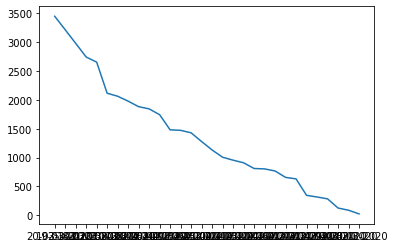

In [10]:
plt.plot(twitter_df['TweetAt'].value_counts())

<AxesSubplot:ylabel='Location'>

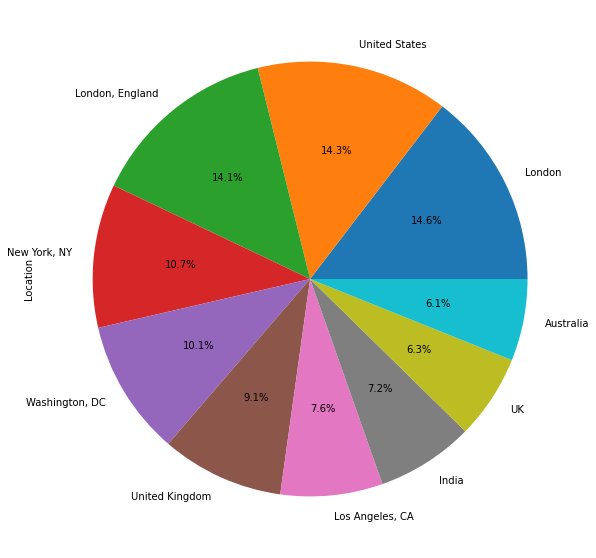

In [11]:
twitter_df['Location'].value_counts().head(10).plot(kind='pie',autopct='%1.1f%%',figsize=(10,10))

## Seperating Hashtag from tweet

In [12]:
hash_train_df=twitter_df[['OriginalTweet','Sentiment']]

In [13]:
def find_hash(tweet):
    hashtags = re.findall("#([a-zA-Z0-9_]{1,50})", tweet)
    return hashtags

In [14]:
def tweet_join(text):
    return " ".join(x for x in text)

In [15]:
hash_train_df['hashtags']=hash_train_df['OriginalTweet'].apply(find_hash)

In [16]:
hash_train_df

,OriginalTweet,Sentiment,hashtags
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,[]
1,advice Talk to your neighbours family to excha...,Positive,[]
2,Coronavirus Australia: Woolworths to give elde...,Positive,[]
3,My food stock is not the only one which is emp...,Positive,"[COVID19france, COVID_19, COVID19, coronavirus..."
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,"[COVID19, coronavirus, CoronavirusFrance, rest..."
...,...,...,...
41152,Airline pilots offering to stock supermarket s...,Neutral,"[NZ, COVID]"
41153,Response to complaint not provided citing COVI...,Extremely Negative,[]
41154,You know its getting tough when @KameronWilds...,Positive,"[coronavirus, toiletpaper]"
41155,Is it wrong that the smell of hand sanitizer i...,Neutral,"[coronavirus, COVID19, coronavirus]"


In [17]:
hash_train_df['hashtags']=hash_train_df['hashtags'].apply(tweet_join)

In [18]:
#all_hashtags = ' '.join([text for text in hash_train_df['hashtags']])

In [19]:
hash_train_df

,OriginalTweet,Sentiment,hashtags
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,
1,advice Talk to your neighbours family to excha...,Positive,
2,Coronavirus Australia: Woolworths to give elde...,Positive,
3,My food stock is not the only one which is emp...,Positive,COVID19france COVID_19 COVID19 coronavirus con...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,COVID19 coronavirus CoronavirusFrance restezch...
...,...,...,...
41152,Airline pilots offering to stock supermarket s...,Neutral,NZ COVID
41153,Response to complaint not provided citing COVI...,Extremely Negative,
41154,You know its getting tough when @KameronWilds...,Positive,coronavirus toiletpaper
41155,Is it wrong that the smell of hand sanitizer i...,Neutral,coronavirus COVID19 coronavirus


In [20]:
x=hash_train_df['hashtags']==''
tweets_wo_hashtag=x.sum()
tweet_with_hashtag=x.count()-x.sum()

In [21]:
print(f"the tweeet percentage without hashtags are {tweets_wo_hashtag/x.count()*100:.2f} %")

the tweeet percentage without hashtags are 42.35 %


In [22]:
positive_words = ' '.join([text for text in hash_train_df['hashtags'][hash_train_df['Sentiment'] == 'Extremely Positive']])
negative_words = ' '.join([text for text in hash_train_df['hashtags'][hash_train_df['Sentiment'] == 'Extremely Negative']])


## Analysing  Hashtags

In [23]:

from nltk.tokenize import word_tokenize
#tweets = twitter_df.tweet.str.cat(sep=' ')
#function to split text into word
tokens = word_tokenize(positive_words)
vocabulary = set(tokens)
print(len(vocabulary))
frequency_dist = nltk.FreqDist(tokens)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:50]

4395


['coronavirus',
 'COVID19',
 'Covid_19',
 'Coronavirus',
 'COVID2019',
 'COVID',
 'covid19',
 'toiletpaper',
 'SocialDistancing',
 'CoronaCrisis',
 'CoronaVirus',
 'StayHomeSaveLives',
 'covid_19',
 'StayAtHome',
 'handsanitizer',
 'socialdistancing',
 'sanitizer',
 'pandemic',
 'StayHome',
 'CoronavirusPandemic',
 'CoronavirusOutbreak',
 'Covid19',
 'staysafe',
 'supermarket',
 'covid',
 'CoronaVirusUpdate',
 'lockdown',
 'shopping',
 'corona',
 'StaySafe',
 'quarantine',
 'StopHoarding',
 'stayhome',
 'retail',
 'covid19UK',
 'panicbuying',
 'Quarantine',
 'QuarantineLife',
 'food',
 'StopPanicBuying',
 'health',
 'CoronavirusUSA',
 'ToiletPaper',
 'Corona',
 'thankyou',
 'NHS',
 'COVID_19',
 'onlineshopping',
 'virus',
 'Retail']

# Cleaning Tweets

In [24]:
def cleaned_tweet(row):
    text=row['OriginalTweet']
    text=tp.clean(text)
    return text

In [25]:
twitter_df['tweet']=twitter_df['OriginalTweet']

In [26]:
twitter_df['tweet']=twitter_df.apply(cleaned_tweet,axis=1)

In [27]:
twitter_df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,and and
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice Talk to your neighbours family to excha...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,Coronavirus Australia: Woolworths to give elde...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,My food stock is not the only one which is emp...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,"Me, ready to go at supermarket during the outb..."
...,...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral,Airline pilots offering to stock supermarket s...
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative,Response to complaint not provided citing COVI...
41154,44953,89905,NaN,14-04-2020,You know its getting tough when @KameronWilds...,Positive,You know its getting tough when is rationing t...
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral,Is it wrong that the smell of hand sanitizer i...


## Remove stopwords 

In [28]:
def stopword_removal(row):
    text = row['tweet']
    text = remove_stopwords(text)
    return text

In [29]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
stop = stopwords.words('english')
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [31]:
twitter_df['tweet'] = twitter_df['tweet'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')

In [32]:
twitter_df['tweet'] = twitter_df['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


In [33]:
twitter_df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,food stock one empty please panic enough food ...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,ready go supermarket outbreak paranoid food st...
...,...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral,airline pilots offering stock supermarket shel...
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative,response complaint provided citing covid 19 re...
41154,44953,89905,NaN,14-04-2020,You know its getting tough when @KameronWilds...,Positive,know getting tough rationing toilet paper mart...
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral,wrong smell hand sanitizer starting turn


## Lemmatisation

In [34]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [(lemmatizer.lemmatize(w)) for w in w_tokenizer.tokenize((text))]

In [35]:
twitter_df['tweet']=twitter_df['tweet'].apply(lemmatize_text)

In [36]:
twitter_df


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,[]
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,"[advice, talk, neighbour, family, exchange, ph..."
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,"[coronavirus, australia, woolworth, give, elde..."
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,"[food, stock, one, empty, please, panic, enoug..."
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,"[ready, go, supermarket, outbreak, paranoid, f..."
...,...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral,"[airline, pilot, offering, stock, supermarket,..."
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative,"[response, complaint, provided, citing, covid,..."
41154,44953,89905,NaN,14-04-2020,You know its getting tough when @KameronWilds...,Positive,"[know, getting, tough, rationing, toilet, pape..."
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral,"[wrong, smell, hand, sanitizer, starting, turn]"


In [37]:
twitter_df['tweet']=twitter_df['tweet'].apply(tweet_join)

In [38]:
twitter_df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbour family exchange phone nu...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworth give elderly d...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,food stock one empty please panic enough food ...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,ready go supermarket outbreak paranoid food st...
...,...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral,airline pilot offering stock supermarket shelf...
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative,response complaint provided citing covid 19 re...
41154,44953,89905,NaN,14-04-2020,You know its getting tough when @KameronWilds...,Positive,know getting tough rationing toilet paper mart...
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral,wrong smell hand sanitizer starting turn


In [39]:
all_words = ' '.join([text for text in twitter_df['tweet']])
positive_words=' '.join([text for text in twitter_df['tweet'][twitter_df['Sentiment']=='Extremely Positive']])
negative_words=' '.join([text for text in twitter_df['tweet'][twitter_df['Sentiment']=='Extremely Negative']])


In [40]:
tokens = word_tokenize(negative_words)
vocabulary = set(tokens)
print(len(vocabulary))
frequency_dist = nltk.FreqDist(tokens)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:50]

11310


['price',
 'food',
 'covid',
 'people',
 'panic',
 '19',
 'supermarket',
 'amp',
 'crisis',
 'store',
 'buying',
 'grocery',
 'consumer',
 'need',
 'get',
 'u',
 'stop',
 'oil',
 'time',
 'go',
 'demand',
 'worker',
 'supply',
 'coronavirus',
 'going',
 'pandemic',
 'scam',
 'shelf',
 'shopping',
 'stock',
 'due',
 'one',
 'home',
 'day',
 'work',
 'week',
 'online',
 'buy',
 'shop',
 'say',
 'virus',
 'fear',
 'toilet',
 'could',
 'like',
 'low',
 'even',
 'market',
 'shortage',
 'paper']

# Cleaned Final datasets

In [41]:
final_train_df=twitter_df[['tweet','Sentiment']]

In [42]:
final_train_df

,tweet,Sentiment
0,,Neutral
1,advice talk neighbour family exchange phone nu...,Positive
2,coronavirus australia woolworth give elderly d...,Positive
3,food stock one empty please panic enough food ...,Positive
4,ready go supermarket outbreak paranoid food st...,Extremely Negative
...,...,...
41152,airline pilot offering stock supermarket shelf...,Neutral
41153,response complaint provided citing covid 19 re...,Extremely Negative
41154,know getting tough rationing toilet paper mart...,Positive
41155,wrong smell hand sanitizer starting turn,Neutral


In [43]:
final_train_df['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [44]:
twitter_test_df=pd.read_csv("C:\\Users\\harsh\\Downloads\\Corona_NLP_test.csv")

In [45]:
twitter_test_df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative


## Cleaning Test data

In [46]:
twitter_test_df['tweet']=twitter_test_df['OriginalTweet']
twitter_test_df['tweet']=twitter_test_df.apply(cleaned_tweet,axis=1)
twitter_test_df['tweet'] = twitter_test_df['tweet'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')
twitter_test_df['tweet'] = twitter_test_df['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
twitter_test_df['tweet']=twitter_test_df['tweet'].apply(lemmatize_text)
twitter_test_df['tweet']=twitter_test_df['tweet'].apply(tweet_join)

In [47]:
final_test_df=twitter_test_df[['tweet','Sentiment']]

In [48]:
final_test_df

,tweet,Sentiment
0,trending new yorkers encounter empty supermark...,Extremely Negative
1,find hand sanitizer fred meyer turned 114 97 p...,Positive
2,find protect loved one,Extremely Positive
3,buying hit city anxious shopper stock food amp...,Negative
4,one week everyone buying baby milk powder next...,Neutral
...,...,...
3793,meanwhile supermarket israel people dance sing...,Positive
3794,panic buy lot non perishable item echo need fo...,Negative
3795,asst prof economics talking recent research co...,Neutral
3796,gov need somethings instead biar je rakyat ass...,Extremely Negative


# Converting Feature Text 

In [49]:
from sklearn.feature_extraction.text import CountVectorizer

vectoriser = CountVectorizer(decode_error = 'replace')
x_train=vectoriser.fit_transform(final_train_df['tweet'].values)
x_test=vectoriser.transform(final_test_df['tweet'].values)
y_train=final_train_df['Sentiment'].values
y_test=final_test_df['Sentiment'].values

In [50]:
models={}

# Classification Models

## Logistic regression

In [51]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

lr.fit(x_train, y_train)

lr_prediction=lr.predict(x_test)

print(classification_report(y_test,lr_prediction))


                    precision    recall  f1-score   support

Extremely Negative       0.67      0.57      0.61       592
Extremely Positive       0.73      0.60      0.66       599
          Negative       0.58      0.56      0.57      1041
           Neutral       0.67      0.75      0.71       619
          Positive       0.57      0.65      0.61       947

          accuracy                           0.62      3798
         macro avg       0.64      0.63      0.63      3798
      weighted avg       0.63      0.62      0.62      3798



In [52]:
lr_accuracy=accuracy_score(y_test,lr_prediction)
lr_f1=f1_score(y_test,lr_prediction,average='weighted')
lr_mcc=matthews_corrcoef(y_test,lr_prediction)


# Random Forest Classification

In [53]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier()
rfc.fit(x_train,y_train)
rfc_prediction=rfc.predict(x_test)



In [54]:
rfc_accuracy=accuracy_score(y_test,rfc_prediction)
rfc_f1=f1_score(y_test,rfc_prediction,average='weighted')
rfc_mcc=matthews_corrcoef(y_test,rfc_prediction)
print(classification_report(y_test,rfc_prediction))

                    precision    recall  f1-score   support

Extremely Negative       0.67      0.29      0.41       592
Extremely Positive       0.69      0.34      0.45       599
          Negative       0.50      0.52      0.51      1041
           Neutral       0.57      0.79      0.67       619
          Positive       0.46      0.63      0.53       947

          accuracy                           0.53      3798
         macro avg       0.58      0.51      0.51      3798
      weighted avg       0.56      0.53      0.51      3798



# Naives Bayes Classifier

In [55]:
from sklearn.naive_bayes import MultinomialNB
nbc=MultinomialNB()
nbc.fit(x_train,y_train)
nbc_prediction=nbc.predict(x_test)

In [56]:
nbc_accuracy=accuracy_score(y_test,nbc_prediction)
nbc_f1=f1_score(y_test,nbc_prediction,average='weighted')
nbc_mcc=matthews_corrcoef(y_test,nbc_prediction)
print(classification_report(y_test,nbc_prediction))

                    precision    recall  f1-score   support

Extremely Negative       0.55      0.36      0.44       592
Extremely Positive       0.66      0.38      0.48       599
          Negative       0.43      0.50      0.47      1041
           Neutral       0.64      0.27      0.38       619
          Positive       0.38      0.63      0.47       947

          accuracy                           0.46      3798
         macro avg       0.53      0.43      0.45      3798
      weighted avg       0.51      0.46      0.45      3798



# Support Vector Machine

In [57]:
from sklearn.svm import SVC 

svc=SVC()
svc.fit(x_train,y_train)
svc_prediction=svc.predict(x_test)

In [58]:
svc_accuracy=accuracy_score(y_test,svc_prediction)
svc_f1=f1_score(y_test,svc_prediction,average='weighted')
svc_mcc=matthews_corrcoef(y_test,svc_prediction)
print(classification_report(y_test,svc_prediction))

                    precision    recall  f1-score   support

Extremely Negative       0.73      0.42      0.53       592
Extremely Positive       0.76      0.52      0.62       599
          Negative       0.53      0.54      0.53      1041
           Neutral       0.62      0.72      0.67       619
          Positive       0.49      0.67      0.57       947

          accuracy                           0.58      3798
         macro avg       0.63      0.57      0.58      3798
      weighted avg       0.60      0.58      0.58      3798



# K Neighbor Classifier

In [59]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=50)
knn.fit(x_train,y_train)
knn_prediction=knn.predict(x_test)

In [60]:
knn_accuracy=accuracy_score(y_test,knn_prediction)
knn_f1=f1_score(y_test,knn_prediction,average='weighted')
knn_mcc=matthews_corrcoef(y_test,knn_prediction)
print(classification_report(y_test,knn_prediction))

                    precision    recall  f1-score   support

Extremely Negative       0.71      0.02      0.03       592
Extremely Positive       1.00      0.00      0.00       599
          Negative       0.23      0.01      0.03      1041
           Neutral       0.17      1.00      0.29       619
          Positive       0.25      0.01      0.03       947

          accuracy                           0.17      3798
         macro avg       0.47      0.21      0.08      3798
      weighted avg       0.42      0.17      0.07      3798



# Stotaistic Gradient Descent

In [61]:
from sklearn.linear_model import SGDClassifier
sgd=SGDClassifier(loss='modified_huber',shuffle=True,random_state=88)
sgd.fit(x_train,y_train)
sgd_prediction=sgd.predict(x_test)


In [62]:
sgd_accuracy=accuracy_score(y_test,sgd_prediction)
sgd_f1=f1_score(y_test,sgd_prediction,average='weighted')
sgd_mcc=matthews_corrcoef(y_test,sgd_prediction)
print(classification_report(y_test,sgd_prediction))

                    precision    recall  f1-score   support

Extremely Negative       0.64      0.63      0.64       592
Extremely Positive       0.70      0.66      0.68       599
          Negative       0.50      0.41      0.45      1041
           Neutral       0.61      0.71      0.66       619
          Positive       0.48      0.54      0.51       947

          accuracy                           0.57      3798
         macro avg       0.59      0.59      0.59      3798
      weighted avg       0.57      0.57      0.56      3798



## Extreme gradient boosting

In [63]:
import xgboost as xgb

xgbc = xgb.XGBClassifier()

xgbc.fit(x_train, y_train)

xgbc_prediction = xgbc.predict(x_test)


[11:56:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [64]:
xgbc_accuracy=accuracy_score(y_test,xgbc_prediction)
xgbc_f1=f1_score(y_test,xgbc_prediction,average='weighted')
xgbc_mcc=matthews_corrcoef(y_test,xgbc_prediction)
print(classification_report(y_test,xgbc_prediction))

                    precision    recall  f1-score   support

Extremely Negative       0.64      0.46      0.54       592
Extremely Positive       0.68      0.52      0.59       599
          Negative       0.54      0.44      0.49      1041
           Neutral       0.51      0.82      0.63       619
          Positive       0.51      0.58      0.54       947

          accuracy                           0.55      3798
         macro avg       0.58      0.56      0.56      3798
      weighted avg       0.57      0.55      0.55      3798



## Accuracy of Models

In [65]:
models={'LR':lr_accuracy,'RFC':rfc_accuracy,'NBC':nbc_accuracy,'SVC':svc_accuracy,'KNN':knn_accuracy,'SGD':sgd_accuracy,'XGB':xgbc_accuracy}

In [66]:
models

{'LR': 0.6232227488151659,
 'RFC': 0.5268562401263823,
 'NBC': 0.4570826750921538,
 'SVC': 0.5779357556608742,
 'KNN': 0.17245918904686677,
 'SGD': 0.5666140073723012,
 'XGB': 0.5526592943654555}

In [67]:
data = {'models': ['LR', 'RFC', 'NBC', 'SVC','KNN','SGD','XGB'],
        'accuracy': [lr_accuracy,rfc_accuracy,nbc_accuracy,svc_accuracy,knn_accuracy,sgd_accuracy,xgbc_accuracy],
        'f1':[lr_f1,rfc_f1,nbc_f1,svc_f1,knn_f1,sgd_f1,xgbc_f1],
        'mcc':[lr_mcc,rfc_mcc,nbc_mcc,svc_mcc,knn_mcc,sgd_mcc,xgbc_mcc]
       } 



In [68]:
models_df=pd.DataFrame.from_dict(data)

Text(0.5, 1.0, 'f1')

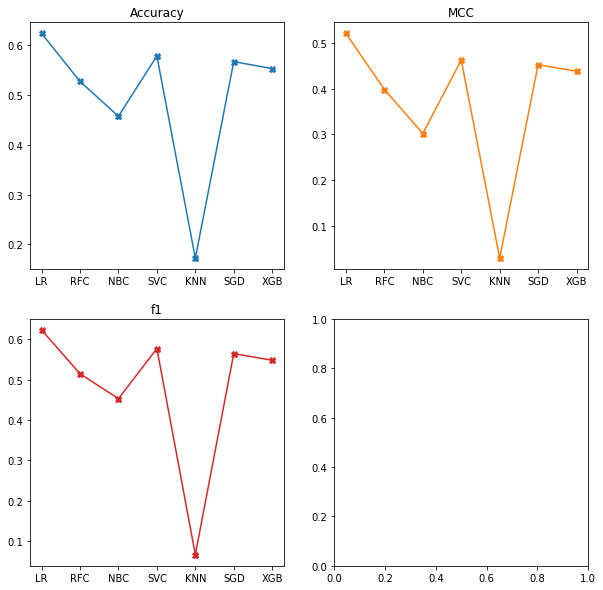

In [69]:
fig, axs = plt.subplots(2, 2,figsize=(10,10))
axs[0, 0].plot(models_df.models, models_df.accuracy,marker='X',label='accuracy')
axs[0, 0].set_title('Accuracy')
axs[0, 1].plot(models_df.models, models_df.mcc, 'tab:orange',marker='X',label='MCC')
axs[0, 1].set_title('MCC')
axs[1, 0].plot(models_df.models, models_df.f1, 'tab:red',marker='X',label='f1')
axs[1, 0].set_title('f1')

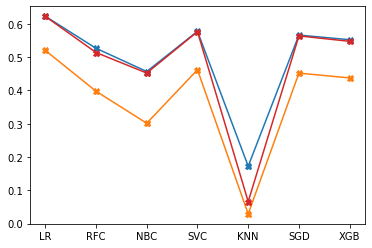

In [70]:
plt.plot(models_df.models, models_df.accuracy,marker='X',label='accuracy')
plt.plot(models_df.models, models_df.mcc, 'tab:orange',marker='X',label='mcc')
plt.plot(models_df.models, models_df.f1, 'tab:red',marker='X',label='f1')
plt.show()

# Hyper parameter tuning for Logistic Regressor

In [71]:
#solvers = ['newton-cg', 'lbfgs', 'liblinear','sag','saga']
solvers=['lbfgs']
penalty = ['l2']
#c_values = [100, 10, 1.0, 0.1, 0.01]
#c_values=[1.10,1.11,0.98,0.9,1.2]
c_values=[1.12]

In [72]:
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=5, random_state=1)
grid_search = GridSearchCV(estimator=lr, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')

In [73]:
grid_result = grid_search.fit(x_train, y_train)
grid_prediction=grid_result.predict(x_test)

In [74]:
grid_accuracy=accuracy_score(y_test,grid_prediction)
grid_f1=f1_score(y_test,grid_prediction,average='macro')
grid_mcc=matthews_corrcoef(y_test,grid_prediction)
print(classification_report(y_test,grid_prediction))
print("MCC using the optimal parameters are ",grid_mcc)

                    precision    recall  f1-score   support

Extremely Negative       0.67      0.57      0.62       592
Extremely Positive       0.73      0.60      0.66       599
          Negative       0.58      0.56      0.57      1041
           Neutral       0.67      0.76      0.71       619
          Positive       0.56      0.65      0.60       947

          accuracy                           0.62      3798
         macro avg       0.64      0.63      0.63      3798
      weighted avg       0.63      0.62      0.62      3798

MCC using the optimal parameters are  0.520756729577039


In [75]:
   print(f"Using parameters {grid_search.best_params_} , we get score {grid_search.best_score_}")

Using parameters {'C': 1.12, 'penalty': 'l2', 'solver': 'lbfgs'} , we get score 0.6509997481873505


In [76]:
grid_f1

0.63216301641548

In [77]:
from sklearn.metrics import confusion_matrix
cnf_matrix=confusion_matrix(y_test,grid_prediction)
cnf_matrix

array([[338,   3, 206,  20,  25],
       [  4, 361,  22,   8, 204],
       [137,  27, 583, 115, 179],
       [  2,   8,  71, 468,  70],
       [ 25,  96, 122,  87, 617]], dtype=int64)

<AxesSubplot:>

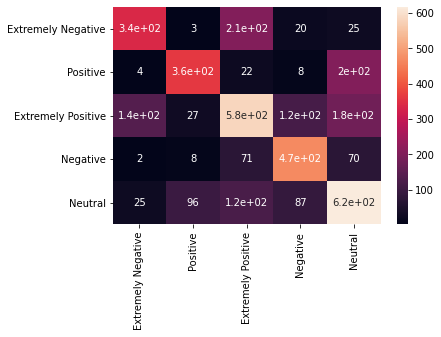

In [78]:
sns.heatmap(cnf_matrix,annot=True,xticklabels=['Extremely Negative', 'Positive', 'Extremely Positive', 'Negative',
       'Neutral'],yticklabels=['Extremely Negative', 'Positive', 'Extremely Positive', 'Negative',
       'Neutral'])

<AxesSubplot:>

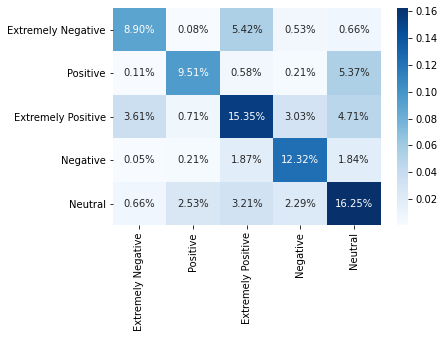

In [79]:
sns.heatmap(cnf_matrix/np.sum(cnf_matrix), annot=True, 
            fmt='.2%', cmap='Blues',xticklabels=['Extremely Negative', 'Positive', 'Extremely Positive', 'Negative',
       'Neutral'],yticklabels=['Extremely Negative', 'Positive', 'Extremely Positive', 'Negative',
       'Neutral'])

The value of MCC is between 1 and -1 where 1 is best model 

========================================================================================================================

## EXTRAS

## Feature Extraction using TFid

In [80]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
train_vectors = x_train
test_vectors = x_test
print(train_vectors.shape, test_vectors.shape)

(41157, 31777) (3798, 31777)


In [81]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(train_vectors, y_train)
tf_nbc_prediction = clf.predict(test_vectors)


In [82]:
tf_nbc_cnf=confusion_matrix(y_test,tf_nbc_prediction)
FP = tf_nbc_cnf.sum(axis=0) - np.diag(tf_nbc_cnf) .astype(float)
FN = tf_nbc_cnf.sum(axis=1) - np.diag(tf_nbc_cnf).astype(float)
TP = np.diag(tf_nbc_cnf).astype(float)
TN = tf_nbc_cnf.sum() - (FP + FN + TP).astype(float)

tf_nbc_accuracy = (TP+TN)/(TP+FP+FN+TN)

print(tf_nbc_accuracy.mean())


0.7828330700368615


In [83]:
syns = wordnet.synsets("help")
print(syns)

[Synset('aid.n.02'), Synset('assistant.n.01'), Synset('aid.n.01'), Synset('avail.n.01'), Synset('help.v.01'), Synset('help.v.02'), Synset('help.v.03'), Synset('help_oneself.v.01'), Synset('serve.v.05'), Synset('help.v.06'), Synset('avail.v.03'), Synset('help.v.08')]


### Testing model with custom input

In [84]:
def clean_text(text):
    text=tp.clean(text)
    text= text.lower().replace('[^\w\s]',' ').replace('\s\s+', ' ')
    text=lemmatize_text(text)
    text=tweet_join(text)
    return text

In [85]:
sample_tweet=vectoriser.transform([clean_text(' joy yay')])
sample_tweet
xgbc.predict(sample_tweet)[0]

'Neutral'

# Converting into binary

In [86]:
bin_train_df=final_train_df
bin_test_df=final_test_df

In [87]:
bin_train_df['Sentiment']=final_train_df['Sentiment'].replace('Positive',1)
bin_train_df['Sentiment']=final_train_df['Sentiment'].replace('Extremely Positive',1)
bin_train_df['Sentiment']=final_train_df['Sentiment'].replace('Neutral',0)
bin_train_df['Sentiment']=final_train_df['Sentiment'].replace('Negative',0)
bin_train_df['Sentiment']=final_train_df['Sentiment'].replace('Extremely Negative',0)

bin_test_df['Sentiment']=final_test_df['Sentiment'].replace('Positive',1)
bin_test_df['Sentiment']=final_test_df['Sentiment'].replace('Extremely Positive',1)
bin_test_df['Sentiment']=final_test_df['Sentiment'].replace('Negative',0)
bin_test_df['Sentiment']=final_test_df['Sentiment'].replace('Extremely Negative',0)
bin_test_df['Sentiment']=final_test_df['Sentiment'].replace('Neutral',0)


In [88]:
bin_train_df['Sentiment'].value_counts()

0    23111
1    18046
Name: Sentiment, dtype: int64

In [89]:
bin_test_df['Sentiment'].value_counts()

0    2252
1    1546
Name: Sentiment, dtype: int64

In [90]:
bin_vectoriser = CountVectorizer(decode_error = 'replace')
x_bin_train=bin_vectoriser.fit_transform(bin_train_df['tweet'].values)
x_bin_test=bin_vectoriser.transform(bin_test_df['tweet'].values)
y_bin_train=bin_train_df['Sentiment'].values
y_bin_test=bin_test_df['Sentiment'].values



In [91]:
bin_lr=LogisticRegression()
bin_lr.fit(x_bin_train, y_bin_train)

lr_bin_prediction=bin_lr.predict(x_bin_test)

print(classification_report(y_bin_test,lr_bin_prediction))


              precision    recall  f1-score   support

           0       0.89      0.90      0.89      2252
           1       0.85      0.83      0.84      1546

    accuracy                           0.87      3798
   macro avg       0.87      0.87      0.87      3798
weighted avg       0.87      0.87      0.87      3798



For the Binary Classification ,Our model gives 87 % accuracy and can increase accuracy upto 90% using optimal parameters